<a href="https://colab.research.google.com/github/m3llad0/fake-news-data-extraction/blob/main/Fake_news_detection_model_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelo de Detección de Noticias Falsas en Español

Este notebook implementa un sistema híbrido basado en modelos de lenguaje (BETO) y Graph Neural Networks (GNNs) para detectar noticias falsas en español. Se justifica el uso de una arquitectura híbrida por la necesidad de capturar tanto patrones lingüísticos (BETO) como metadatos y relaciones contextuales (GNN).

## 0. Configuración del entorno y librerías

Se importan las librerías necesarias para construir el modelo de detección de noticias falsas.

- `torch`: framework principal para redes neuronales y entrenamiento en GPU.
- `transformers`: permite cargar modelos preentrenados como BETO desde HuggingFace.
- `numpy`, `pandas`: utilizadas para manipulación de datos.
- `requests`: utilizada para acceder al dataset alojado vía una API externa.

También se verifica la disponibilidad de GPU, lo cual es relevante para acelerar el entrenamiento de modelos grandes como BETO. Si se dispone de una GPU (por ejemplo, Tesla T4 en Colab), el entrenamiento y la inferencia serán considerablemente más rápidos.

In [22]:
import torch
from transformers import AutoModel, AutoTokenizer
import requests
import numpy as np
import pandas as pd


In [23]:
print("PyTorch version:", torch.__version__)
print("GPU Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))


PyTorch version: 2.8.0+cu126
GPU Available: True
GPU Name: Tesla T4


## 1. Carga de datos

El conjunto de datos se obtiene mediante una solicitud HTTP (`GET`) a una API propia alojada en Azure. Esta API expone una lista de noticias previamente recolectadas y etiquetadas, bajo el campo `"Scrapped news"`.

Cada noticia contiene:
- `TITULO`: encabezado de la noticia.
- `CORPUS`: cuerpo del texto.
- `VERACIDAD`: etiqueta binaria (`'true'` o `'false'`).

### 1.1 Preprocesamiento
Se realiza un preprocesamiento inicial para construir el texto de entrada y la etiqueta de clase:
- Se concatena el título y el cuerpo para formar una sola secuencia (`text`).
- Se mapea la etiqueta `VERACIDAD` a valores numéricos:  
  - `0` para noticias reales  
  - `1` para noticias falsas

Este formato es necesario para alimentar el modelo de lenguaje que se usará en las siguientes etapas.



In [24]:

# API endpoint
ROUTE = "https://my-thesis-aaacd0bxgzfae8a0.westus-01.azurewebsites.net/dataset"

# Fetch the data
response = requests.get(ROUTE)
data = response.json()

# Extract 'Scrapped news' list
news_items = data["Scrapped news"]

# Convert to DataFrame
df = pd.DataFrame(news_items)

# Preprocess the dataset for model input
df['text'] = df['TITULO'] + ". " + df['CORPUS']
df['label'] = df['VERACIDAD'].map({'true': 0, 'false': 1, "satira":2})  # Map veracity to binary labels


# Final dataset ready for model
dataset = df[['text', 'label']]


In [25]:
dataset.head()

,text,label
0,Oxford lanza sus propios exámenes de certifica...,0
1,La RAE estudia incluir «machirulo» en el Dicci...,0
2,Realizan paro en Facultad de Ciencias Política...,0
3,Deniegan el B1 a un joven mudo por no poder ap...,1
4,Jorge Vergara recapacita y ofrece precios más ...,1


## 2. Creación de modelo

## 2.1 Inicialización del modelo BETO

Se carga el modelo `dccuchile/bert-base-spanish-wwm-cased`, una versión de BERT entrenada en corpus en español con *Whole Word Masking* (WWM), lo que permite capturar mejor las propiedades léxicas y sintácticas del idioma.

También se carga el tokenizador correspondiente, que convierte cada texto en una secuencia de tokens con padding y truncamiento adecuados. Esta etapa garantiza que la entrada al modelo sea coherente y consistente con el preentrenamiento original.


In [26]:
tokenizer = AutoTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-cased")
beto_model = AutoModel.from_pretrained("dccuchile/bert-base-spanish-wwm-cased")

Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 2.2 Definición de arquitectura de clasificación (BETO + MLP)

La arquitectura del modelo se compone de dos partes:

1. **BETO** actúa como extractor de características (encoder), generando embeddings para cada token del texto.
2. **Cabeza de clasificación (MLP):**
   - Se extrae el vector `[CLS]` como representación del texto completo.
   - Se pasa por dos capas densas:
     - `Linear(768 → 256)` con activación ReLU y Dropout.
     - `Linear(256 → 2)` para salida binaria (real o falsa).

> Esta estructura forma un **MLP (Multilayer Perceptron)** superficial que aprende a clasificar el embedding global en una de las dos clases.

El modelo se entrena con:
- `CrossEntropyLoss`: para clasificación multiclase.
- `AdamW`: optimizador adaptado con regularización L2.

La arquitectura se mueve a GPU si está disponible.


In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Definición del modelo
dropout = nn.Dropout(0.3)
dense1 = nn.Linear(beto_model.config.hidden_size, 256)
dense2 = nn.Linear(256, 3)  # 2 clases (softmax implícito en la pérdida)

# Mover a GPU
beto_model.to(device)
dropout.to(device)
dense1.to(device)
dense2.to(device)

# Definición de función forward
def model_forward(input_ids, attention_mask):
    outputs = beto_model(input_ids=input_ids, attention_mask=attention_mask)
    cls_output = outputs.last_hidden_state[:, 0, :]  # [CLS] token

    x = dropout(cls_output)
    x = F.relu(dense1(x))
    x = dropout(x)
    logits = dense2(x)

    return logits

# Pérdida y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(
    list(beto_model.parameters()) + list(dense1.parameters()) + list(dense2.parameters()),
    lr=2e-5
)

# Mostrar resumen básico
print("Modelo listo. Capas adicionales:\n", dense1, dense2)


Modelo listo. Capas adicionales:
 Linear(in_features=768, out_features=256, bias=True) Linear(in_features=256, out_features=3, bias=True)


### 2.3 División del dataset y tokenización

Se divide el conjunto de datos en entrenamiento (80%) y validación (20%) usando `train_test_split` estratificado, para preservar la proporción entre clases reales y falsas.

Luego, los textos se tokenizan utilizando el tokenizador de BETO:
- Truncamiento a máximo 512 tokens.
- Padding automático.
- Salida como tensores PyTorch (`return_tensors="pt"`).

Esta representación será utilizada como entrada al modelo en la etapa de entrenamiento. La tokenización garantiza que el texto esté alineado con el vocabulario y segmentación aprendidos durante el preentrenamiento de BETO.


In [28]:
from sklearn.model_selection import train_test_split

# Split data
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

# Flatten labels
train_labels = train_labels.values.flatten()
val_labels = val_labels.values.flatten()

# Tokenize text con salida en PyTorch
train_encodings = tokenizer(
    list(train_texts),
    truncation=True,
    padding=True,
    max_length=512,
    return_tensors="pt"
)

val_encodings = tokenizer(
    list(val_texts),
    truncation=True,
    padding=True,
    max_length=512,
    return_tensors="pt"
)


## 3. Entrenamiento del modelo textual (BETO + MLP)

### 🔧 Preparación
- Se entrena el modelo por un máximo de **20 épocas** con un `batch size` de 8.
- Se aplica **regularización L2** (`weight_decay=1e-4`) y **Dropout del 30%** para mitigar el sobreajuste.
- Se calculan los pesos por clase con `class_weight='balanced'` para compensar el posible desbalance entre noticias reales y falsas.
- Se utiliza `CrossEntropyLoss` ponderada como función de pérdida y `Adam` como optimizador.

### 3.1 Bucle de entrenamiento
Por cada época:
1. Se realiza entrenamiento en el conjunto de entrenamiento y evaluación en el de validación.
2. Se almacenan métricas clave: pérdida (`loss`) y precisión (`accuracy`) en ambos conjuntos.
3. Se imprime el desempeño actual incluyendo la tasa de aprendizaje.
4. Se aplica `ReduceLROnPlateau` como **scheduler dinámico** que reduce la tasa de aprendizaje si la pérdida de validación no mejora.
5. Se implementa **early stopping** con `patience = 3`, deteniendo el entrenamiento si no se detecta mejora.

### 3.2 Restauración del mejor modelo
Al finalizar el entrenamiento (o al activarse early stopping), se restauran los pesos del modelo con mejor desempeño en validación, preservando así el mejor punto del entrenamiento.


In [29]:
import torch
import numpy as np
from sklearn.utils import class_weight
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt

EPOCHS = 20
BATCH_SIZE = 8
PATIENCE = 3

dropout = torch.nn.Dropout(0.3)  # Increased regularization

optimizer = torch.optim.Adam(
    list(beto_model.parameters()) + list(dense1.parameters()) + list(dense2.parameters()),
    lr=2e-5,
    weight_decay=1e-4
)



# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)

# Create DataLoaders
train_dataset = TensorDataset(
    train_encodings['input_ids'],
    train_encodings['attention_mask'],
    torch.tensor(train_labels)
)

val_dataset = TensorDataset(
    val_encodings['input_ids'],
    val_encodings['attention_mask'],
    torch.tensor(val_labels)
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# Scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1)

# Metrics
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

best_val_loss = np.inf
best_model_state = None
patience_counter = 0

# Training loop
for epoch in range(EPOCHS):
    beto_model.train()
    dense1.train()
    dense2.train()

    running_loss = 0
    correct, total = 0, 0

    for batch in train_loader:
        input_ids, attention_mask, labels = [x.to(device) for x in batch]

        optimizer.zero_grad()
        outputs = model_forward(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    # Validation
    beto_model.eval()
    dense1.eval()
    dense2.eval()

    val_running_loss = 0
    val_correct, val_total = 0, 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = [x.to(device) for x in batch]
            outputs = model_forward(input_ids, attention_mask)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item()
            preds = outputs.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = val_running_loss / len(val_loader)
    val_acc = val_correct / val_total

    # Save metrics
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    # Print status
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1} | LR: {current_lr:.6f} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | "
          f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    # Scheduler step
    scheduler.step(avg_val_loss)

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = {
            "beto": beto_model.state_dict(),
            "dense1": dense1.state_dict(),
            "dense2": dense2.state_dict()
        }
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print("Early stopping triggered.")
            break

# Restore best model
beto_model.load_state_dict(best_model_state["beto"])
dense1.load_state_dict(best_model_state["dense1"])
dense2.load_state_dict(best_model_state["dense2"])

Epoch 1 | LR: 0.000020 | Train Loss: 0.9162 | Val Loss: 0.7242 | Train Acc: 0.5395 | Val Acc: 0.6385
Epoch 2 | LR: 0.000020 | Train Loss: 0.5736 | Val Loss: 0.5397 | Train Acc: 0.7601 | Val Acc: 0.7962
Epoch 3 | LR: 0.000020 | Train Loss: 0.2646 | Val Loss: 0.4671 | Train Acc: 0.9046 | Val Acc: 0.8308
Epoch 4 | LR: 0.000020 | Train Loss: 0.1567 | Val Loss: 0.4700 | Train Acc: 0.9538 | Val Acc: 0.8385
Epoch 5 | LR: 0.000020 | Train Loss: 0.0811 | Val Loss: 0.5521 | Train Acc: 0.9730 | Val Acc: 0.8462
Epoch 6 | LR: 0.000010 | Train Loss: 0.0344 | Val Loss: 0.5974 | Train Acc: 0.9913 | Val Acc: 0.8385
Early stopping triggered.


<All keys matched successfully>

## 4. Visualización de métricas y evaluación del modelo textual

### 4.1 Precisión y pérdida a lo largo de las épocas

Se grafican las curvas de `accuracy` y `loss` tanto para el conjunto de entrenamiento como para el de validación.

#### 4.2 Observaciones:
- La precisión en entrenamiento alcanza casi el 100%, mientras que en validación se estabiliza cerca del 86%.
- La pérdida de entrenamiento disminuye continuamente, pero la de validación comienza a subir después de la época 2.

> Estos patrones son consistentes con **sobreajuste**, indicando que el modelo aprende muy bien el set de entrenamiento pero generaliza moderadamente al set de validación.



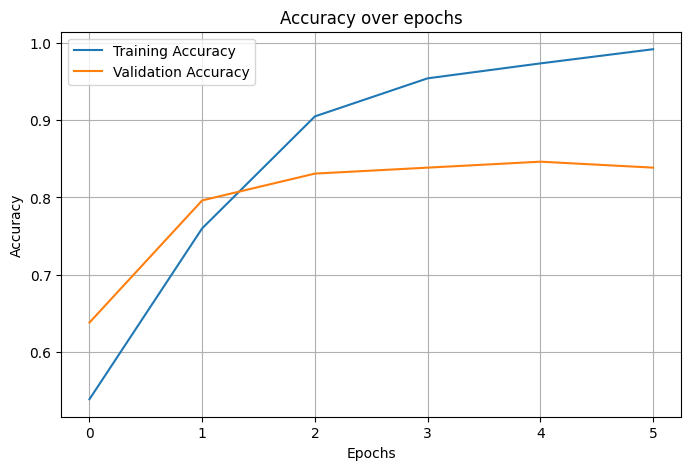

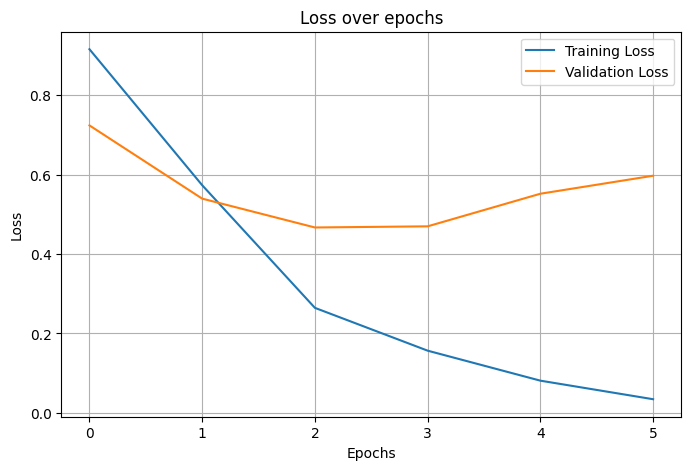

In [30]:
import matplotlib.pyplot as plt

# Accuracy
plt.figure(figsize=(8,5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


### 4.3 Evaluación cuantitativa (classification report)

Se calcula un reporte detallado con precisión, recall y F1-score por clase.

- **Accuracy global:** 0.86
- **Macro F1:** 0.86

#### 4.3.1 Análisis:
- El modelo **identifica muy bien noticias reales** (recall del 94%), pero **omite una proporción considerable de noticias falsas** (recall del 77%).
- Esto sugiere que el modelo confunde algunas noticias falsas con verdaderas, posiblemente debido a redacción formal o ambigüedad semántica.




In [31]:
from sklearn.metrics import f1_score, classification_report
import torch

# Modo evaluación
beto_model.eval()
dense1.eval()
dense2.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids, attention_mask, labels = [x.to(device) for x in batch]

        outputs = model_forward(input_ids, attention_mask)
        preds = outputs.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Reporte de métricas
print(classification_report(all_labels, all_preds, target_names=["Real", "Fake", "Satira"]))


              precision    recall  f1-score   support

        Real       0.88      0.89      0.88        87
        Fake       0.73      0.86      0.79        86
      Satira       0.97      0.78      0.87        87

    accuracy                           0.84       260
   macro avg       0.86      0.84      0.84       260
weighted avg       0.86      0.84      0.84       260



### 4.4 Matriz de confusión

La matriz muestra los errores más relevantes del modelo en validación.

- **Falsos positivos:** 8 reales etiquetadas como falsas.
- **Falsos negativos:** 23 falsas clasificadas como reales.

> El mayor error está en las **falsas negativas**, lo que impacta negativamente el recall de la clase “Fake”.


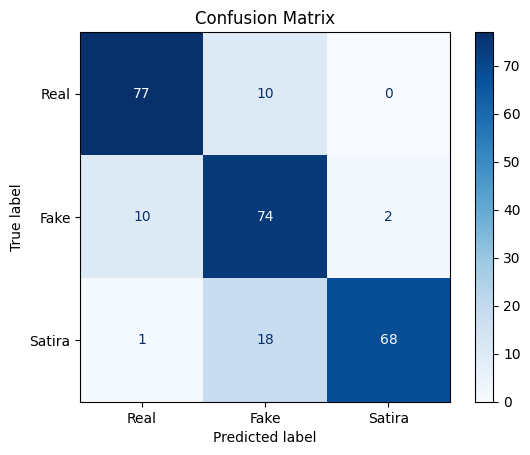

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Ya tienes all_preds y all_labels del paso anterior

cm = confusion_matrix(all_labels, all_preds)
labels = ["Real", "Fake", "Satira"]

# Mostrar matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


### 4.5 Conclusión

- El modelo logra un buen desempeño general como línea base, con un F1 de 0.86 y buena estabilidad.
- El sobreajuste observado y los errores en noticias falsas justifican continuar con la incorporación de contexto estructural (GNN) y técnicas de regularización o augmentación.

## 5. Creación del modelo híbrido

### 5.1 Construcción de features estructurales para la GNN

En esta sección se construye un conjunto de **metadatos enriquecidos** que representan cada noticia como un nodo con atributos numéricos. Estos atributos no se basan en el contenido textual en sí, sino en señales de contexto y estructura, lo que permite entrenar una red neuronal de grafos (GNN) que capte relaciones implícitas entre noticias.

---

### 5.1.1 Atributos incluidos

1. **`LABEL`**  
   Etiqueta binaria de veracidad (0 = real, 1 = falsa), igual que en el modelo textual.

2. **`FUENTE_COD`**  
   Codificación del autor o fuente de la noticia. Se usa `LabelEncoder` para transformar valores categóricos a enteros. Las fuentes desconocidas se rellenan con `"desconocido"`.

3. **`FECHA_NUM`**  
   Representación de la fecha de publicación como número de días desde una fecha base (`2023-01-01`). Esto permite tratar la fecha como una variable continua.

4. **`LONGITUD`**  
   Cantidad de palabras del texto completo (`título + cuerpo`). Las noticias extremadamente cortas o largas pueden correlacionarse con ciertos tipos de desinformación.

5. **`POLARIDAD`**  
   Sentimiento del texto calculado con `TextBlob` (rango de -1 a 1). Las noticias con polarización extrema podrían ser más susceptibles a contener sesgos o emociones.



In [33]:
df.head()

,AUTOR,CORPUS,FECHA,METADATA,TITULO,URL,VERACIDAD,text,label
0,Heraldo De Aragón,La Universidad de Oxford lanza en España su nu...,2017-04-05 00:00:00,"defaultdict(<class 'dict'>, {'viewport': 'widt...",Oxford lanza sus propios exámenes de certifica...,https://www.heraldo.es/noticias/sociedad/2017/...,true,Oxford lanza sus propios exámenes de certifica...,0
1,Ernesto Agudo,"Darío Villanueva, director de la RAE, en una r...",2018-06-26 13:51:37+02:00,"defaultdict(<class 'dict'>, {'lang': 'es', 'vi...",La RAE estudia incluir «machirulo» en el Dicci...,https://www.abc.es/cultura/abci-estudia-inclui...,true,La RAE estudia incluir «machirulo» en el Dicci...,0
2,"Pedro, Villa Y Caña, Pedro Villa Y Caña, Ver P...",Estudiantes de la F acultad de Ciencias Políti...,,"defaultdict(<class 'dict'>, {'viewport': 'widt...",Realizan paro en Facultad de Ciencias Política...,http://www.eluniversal.com.mx/nacion/sociedad/...,true,Realizan paro en Facultad de Ciencias Política...,0
3,Dios De La Guerra Y Referente Del Humor Period...,This post has already been read 3168 times!\n\...,2018-01-18 08:47:27+00:00,"defaultdict(<class 'dict'>, {'viewport': 'widt...",Deniegan el B1 a un joven mudo por no poder ap...,https://haynoticia.es/deniegan-b1-joven-mudo-n...,false,Deniegan el B1 a un joven mudo por no poder ap...,1
4,Yako Daniel,"El señor Jorge Vergara, dueño del Club Guada...",2016-06-30 01:19:18+00:00,"defaultdict(<class 'dict'>, {'viewport': 'widt...",Jorge Vergara recapacita y ofrece precios más ...,https://www.eldizque.com/jorge-vergara-recapac...,false,Jorge Vergara recapacita y ofrece precios más ...,1


In [34]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from textblob import TextBlob

# Crear dataset limpio
gnn_data = pd.DataFrame()

# Texto y label
gnn_data['TEXTO'] = df['TITULO'].fillna('').astype(str) + ". " + df['CORPUS'].fillna('').astype(str)
gnn_data['LABEL'] = df['VERACIDAD'].map({'true': 0, 'false': 1, "satira": 2})

# Fuente / Dominio
gnn_data['FUENTE'] = df['AUTOR'].fillna('desconocido').astype(str)
le_fuente = LabelEncoder()
gnn_data['FUENTE_COD'] = le_fuente.fit_transform(gnn_data['FUENTE'])

# Fecha a número (días desde 2023-01-01)
fecha_col = pd.to_datetime(df['FECHA'], errors='coerce')
fecha_base = pd.Timestamp('2023-01-01')
# Serie de días (puede contener NaN)
fecha_num = (fecha_col - fecha_base).dt.days
# Imputación simple (si todas son NaN → 0)
if fecha_num.notna().any():
    fecha_num = fecha_num.fillna(fecha_num.median())
else:
    fecha_num = pd.Series(0, index=df.index, dtype=float)

gnn_data['FECHA_NUM'] = fecha_num.astype(float)

# Longitud del texto
gnn_data['LONGITUD'] = gnn_data['TEXTO'].str.split().str.len()

# Polaridad
def get_sentiment(text):
    try:
        return TextBlob(str(text)).sentiment.polarity
    except Exception:
        return 0.0

gnn_data['POLARIDAD'] = gnn_data['TEXTO'].apply(get_sentiment)

gnn_data.head()


,TEXTO,LABEL,FUENTE,FUENTE_COD,FECHA_NUM,LONGITUD,POLARIDAD
0,Oxford lanza sus propios exámenes de certifica...,0,Heraldo De Aragón,131,-2097.0,360,0.0000
1,La RAE estudia incluir «machirulo» en el Dicci...,0,Ernesto Agudo,106,-918.0,406,0.2875
2,Realizan paro en Facultad de Ciencias Política...,0,"Pedro, Villa Y Caña, Pedro Villa Y Caña, Ver P...",267,-918.0,386,0.5000
3,Deniegan el B1 a un joven mudo por no poder ap...,1,Dios De La Guerra Y Referente Del Humor Period...,78,-918.0,219,0.0000
4,Jorge Vergara recapacita y ofrece precios más ...,1,Yako Daniel,372,-918.0,255,0.0000


#### 5.1.2 Detección de Clickbait

Se utiliza el modelo `taniwasl/clickbait_es` (HuggingFace) para calcular un **score de clickbait** a partir del título de la noticia.

- Se define un pipeline con `TextClassificationPipeline` que devuelve todas las probabilidades por clase.
- Se extrae la probabilidad correspondiente a la clase “clickbait”.
- El resultado es un valor continuo entre 0 y 1 asignado a la columna `CLICKBAIT`.

> Este puntaje refleja la probabilidad de que el título de una noticia tenga intención de atraer clics mediante lenguaje exagerado, sensacionalista o ambiguo.


In [35]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TextClassificationPipeline

clickbait_model = "taniwasl/clickbait_es"

tokenizer_cb = AutoTokenizer.from_pretrained(clickbait_model)
model_cb = AutoModelForSequenceClassification.from_pretrained(clickbait_model)

cb_pipeline = TextClassificationPipeline(
    model=model_cb,
    tokenizer=tokenizer_cb,
    return_all_scores=True,
    function_to_apply="softmax",
    top_k=None
)


Device set to use cuda:0


### 5.1.3 Resultado

El dataframe `gnn_data` contiene ahora las siguientes variables por nodo:

- TEXTO (para referencia)
- LABEL (0 o 1)
- FUENTE_COD (entero)
- FECHA_NUM (entero)
- LONGITUD (entero)
- POLARIDAD (float)
- CLICKBAIT (float)

Este vector de características representa el perfil contextual de cada noticia y será utilizado como entrada para construir un grafo de similitud y entrenar el modelo GNN.

In [36]:
def clickbait_score(title: str) -> float:
    res = cb_pipeline(title[:128])
    for score_dict in res[0]:
        if score_dict['label'].lower() in ['clickbait', 'click_bait', 'click-bait']:
            return score_dict['score']
    return res[0][0]['score']

gnn_data['CLICKBAIT'] = df['TITULO'].apply(clickbait_score)

gnn_data

,TEXTO,LABEL,FUENTE,FUENTE_COD,FECHA_NUM,LONGITUD,POLARIDAD,CLICKBAIT
0,Oxford lanza sus propios exámenes de certifica...,0,Heraldo De Aragón,131,-2097.0,360,0.0000,0.000041
1,La RAE estudia incluir «machirulo» en el Dicci...,0,Ernesto Agudo,106,-918.0,406,0.2875,0.264995
2,Realizan paro en Facultad de Ciencias Política...,0,"Pedro, Villa Y Caña, Pedro Villa Y Caña, Ver P...",267,-918.0,386,0.5000,0.000055
3,Deniegan el B1 a un joven mudo por no poder ap...,1,Dios De La Guerra Y Referente Del Humor Period...,78,-918.0,219,0.0000,0.017519
4,Jorge Vergara recapacita y ofrece precios más ...,1,Yako Daniel,372,-918.0,255,0.0000,0.000238
...,...,...,...,...,...,...,...,...
1293,Tras la llegada de Speed al Perú: Banco Mundia...,2,,0,-918.0,267,0.0000,0.000031
1294,"Speed fue alcalde por dos horas, y en ese tiem...",2,,0,-918.0,247,0.0000,0.906690
1295,López Aliaga niega haber embarazado a madre de...,2,,0,-918.0,322,0.0000,0.998917
1296,Vaticano confirma que reunirse con el PAPA afu...,2,,0,-918.0,235,0.0500,0.000041


### 5.1.4 Normalización de metadatos y ensamblado del vector estructural

Para que la red neuronal de grafos procese correctamente los metadatos, es necesario normalizar las variables numéricas a un rango comparable. Se utiliza `MinMaxScaler` para escalar los siguientes atributos al intervalo [0, 1]:

- `FECHA_NUM` → `FECHA_NORM`
- `LONGITUD` → `LONGITUD_NORM`
- `POLARIDAD` → `POLARIDAD_NORM`
- `CLICKBAIT` → `CLICKBAIT_NORM`

Luego, se construye la **matriz final de metadatos** (`metadata_gnn`) concatenando:

1. `FUENTE_COD` → codificación entera de la fuente (no normalizada).
2. Atributos normalizados: fecha, longitud, polaridad y clickbait.

Este vector representa cada nodo (noticia) en el grafo mediante un conjunto de **características estructurales y semánticas suaves**, que serán procesadas posteriormente por la GNN para capturar relaciones no evidentes entre noticias.

> Esta representación es independiente del contenido textual y permite explotar patrones relacionados con estilo, fuente, tono y temporalidad.


In [37]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Índices de train/test (estratificado en la etiqueta)
idx_all = np.arange(len(gnn_data))
train_idx, test_idx = train_test_split(
    idx_all,
    test_size=0.2,
    random_state=42,
    stratify=gnn_data['LABEL']
)

# Features numéricas sin normalizar (orden explícito)
# 1=LONGITUD, 2=POLARIDAD, 3=CLICKBAIT, 4=FECHA_NUM
X_num = gnn_data[['LONGITUD', 'POLARIDAD', 'CLICKBAIT', 'FECHA_NUM']].to_numpy(dtype=float)

# Split
X_num_train = X_num[train_idx]
X_num_test  = X_num[test_idx]

# Escalado solo con TRAIN (evita fuga)
scaler = MinMaxScaler().fit(X_num_train)
X_num_train_scaled = scaler.transform(X_num_train)
X_num_test_scaled  = scaler.transform(X_num_test)

# Fuente codificada (queda como primera columna, SIN escalar)
fuente_all = gnn_data['FUENTE_COD'].to_numpy().reshape(-1,1)
fuente_train = fuente_all[train_idx]
fuente_test  = fuente_all[test_idx]


metadata_train = np.concatenate([fuente_train, X_num_train_scaled], axis=1).astype(np.float32)
metadata_test  = np.concatenate([fuente_test , X_num_test_scaled ], axis=1).astype(np.float32)

meta_train = metadata_train
meta_test  = metadata_test


metadata_gnn = np.concatenate([metadata_train, metadata_test], axis=0)

print("metadata_train/test:", metadata_train.shape, metadata_test.shape)


metadata_train/test: (1038, 5) (260, 5)


## 6. Arquitectura Modelo Híbrido

### 6.1 Extracción de embeddings con BETO

Se utiliza el modelo `beto_model` (ya entrenado o congelado) para generar representaciones vectoriales (`embeddings`) de cada noticia a partir del token `[CLS]`.

Pasos:
1. Se tokeniza todo el texto (`TÍTULO + CUERPO`) y se almacena en un `DataLoader`.
2. Se desactiva el cálculo de gradientes (`torch.no_grad()`).
3. Para cada batch, se extrae el embedding del token `[CLS]` y se almacena.
4. Finalmente, se concatenan todos los vectores obtenidos (uno por noticia), obteniendo una matriz de embeddings de dimensión `(n_samples, 768)`.

Estos vectores representan el **contenido textual** de cada noticia en un espacio semántico preentrenado.


In [38]:
def generate_embeddings(text_list, batch_size=8):
    encodings = tokenizer(
        list(text_list),
        truncation=True,
        padding=True,
        max_length=512,
        return_tensors="pt"
    )

    dataset = TensorDataset(encodings['input_ids'], encodings['attention_mask'])
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    beto_model.eval()
    all_cls = []

    with torch.no_grad():
        for input_ids_batch, attention_mask_batch in loader:
            input_ids_batch = input_ids_batch.to(device)
            attention_mask_batch = attention_mask_batch.to(device)

            outputs = beto_model(input_ids=input_ids_batch, attention_mask=attention_mask_batch)
            cls_embeddings = outputs.last_hidden_state[:, 0, :]
            all_cls.append(cls_embeddings.cpu())

    return torch.cat(all_cls, dim=0).numpy()

In [39]:



labels = gnn_data['LABEL'].to_numpy()
texts  = gnn_data['TEXTO'].to_numpy()

texts_train = texts[train_idx]
texts_test  = texts[test_idx]
y_train = labels[train_idx]
y_test  = labels[test_idx]

# Usa tus funciones intactas
X_text_train = generate_embeddings(texts_train)
X_text_test  = generate_embeddings(texts_test)

# Asegura dtype consistente
X_meta_train = meta_train.astype(np.float32)
X_meta_test  = meta_test.astype(np.float32)

print("X_text_train/test:", X_text_train.shape, X_text_test.shape)
print("X_meta_train/test:", X_meta_train.shape, X_meta_test.shape)


X_text_train/test: (1038, 768) (260, 768)
X_meta_train/test: (1038, 5) (260, 5)


In [40]:
# from torch.utils.data import DataLoader, TensorDataset

# # Tokenizar todo pero sin pasar a tensor gigante
# encodings = tokenizer(
#     list(gnn_data['TEXTO']),
#     truncation=True,
#     padding=True,
#     max_length=512,
#     return_tensors="pt"
# )

# # Crear DataLoader sin clases personalizadas
# input_ids = encodings['input_ids']
# attention_mask = encodings['attention_mask']

# dataset = TensorDataset(input_ids, attention_mask)
# loader = DataLoader(dataset, batch_size=8, shuffle=False)

# # Modo evaluación
# beto_model.eval()
# all_embeddings = []

# with torch.no_grad():
#     for batch in loader:
#         input_ids_batch, attention_mask_batch = [x.to(device) for x in batch]
#         outputs = beto_model(input_ids=input_ids_batch, attention_mask=attention_mask_batch)
#         cls_batch = outputs.last_hidden_state[:, 0, :]  # CLS token
#         all_embeddings.append(cls_batch.cpu())

# # Concatenar todos los embeddings
# embeddings = torch.cat(all_embeddings, dim=0).numpy()


## 6.2 División del dataset para modelo híbrido

Se utiliza `train_test_split` para dividir el conjunto completo de:
- Embeddings del texto (`X_text`)
- Metadatos estructurales (`X_meta`)
- Etiquetas (`y`)

Esto permite evaluar de manera justa el modelo híbrido posterior, asegurando que las relaciones en el grafo también estén divididas entre entrenamiento y prueba. El `random_state` se fija para reproducibilidad.


## 6.3 Construcción del grafo de similitud semántica

Se construyen dos grafos de adyacencia (uno para entrenamiento y otro para prueba) basados en la **similitud coseno** entre los embeddings de texto.

- Se calcula la matriz de similitud coseno entre pares de noticias.
- Se aplica un umbral de corte: si la similitud es > 0.8, se considera que hay una arista entre los nodos (noticias).
- Se elimina la diagonal (auto-conexiones).
- Se convierte la matriz densa a formato disperso (`scipy.sparse`) para eficiencia.

> Este grafo captura relaciones implícitas entre noticias con contenido textual altamente similar, incluso si no comparten fuente o fecha.


In [41]:
fuentes_train = meta_train[:, 0]
fechas_train      = meta_train[:, 4]   # FECHA_NORM
polaridades_train = meta_train[:, 2]


In [42]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

n = len(X_text_train)

# Cosine similarity con umbral aleatorio por epoch
sim_text = cosine_similarity(X_text_train)
threshold = np.random.uniform(0.7, 0.85)
adj_text_train = (sim_text > threshold).astype(np.float32)

# Misma fuente
adj_fuente_train = np.equal.outer(fuentes_train, fuentes_train).astype(np.float32)

# Fecha cercana (diferencia ≤ 0.05 en escala normalizada)
adj_fecha_train = (np.abs(fechas_train[:, None] - fechas_train[None, :]) <= 0.05).astype(np.float32)

# Polaridad similar (diferencia ≤ 0.1)
adj_polaridad_train = (np.abs(polaridades_train[:, None] - polaridades_train[None, :]) <= 0.1).astype(np.float32)

# Combinar
adj_enriched_train = np.clip(
    adj_text_train + adj_fuente_train + adj_fecha_train + adj_polaridad_train,
    0, 1
)
np.fill_diagonal(adj_enriched_train, 0)


In [43]:
fuentes_test = meta_test[:, 0]
fechas_test      = meta_test[:, 4]     # FECHA_NORM
polaridades_test = meta_test[:, 2]   # Suponiendo ya está normalizada

# 1. Similitud coseno (texto)
sim_text_test = cosine_similarity(X_text_test)
adj_text_test = (sim_text_test > 0.8).astype(np.float32)

# 2. Misma fuente
adj_fuente_test = np.equal.outer(fuentes_test, fuentes_test).astype(np.float32)

# 3. Fecha cercana (normalizada)
adj_fecha_test = (np.abs(fechas_test[:, None] - fechas_test[None, :]) <= 0.05).astype(np.float32)

# 4. Polaridad similar
adj_polaridad_test = (np.abs(polaridades_test[:, None] - polaridades_test[None, :]) <= 0.1).astype(np.float32)

# 5. Combinar todo (OR lógico)
adj_enriched_test = np.clip(
    adj_text_test + adj_fuente_test + adj_fecha_test + adj_polaridad_test,
    0, 1
)
np.fill_diagonal(adj_enriched_test, 0)


In [44]:
!pip install torch-geometric

### 6.4 Definición del modelo híbrido (BETO + GCN)

Se define una arquitectura que combina:
- **Embeddings de texto (768 dim)** obtenidos por BETO.
- **Metadatos procesados con GCN**, que modela la estructura del grafo.

#### 6.4.1 Arquitectura:

1. `meta_fc` (Linear): transforma los metadatos de entrada (5 características) a 64 dimensiones.
2. `GCNConv`: aplica una convolución de grafos que propaga información entre nodos vecinos en el grafo de similitud.
3. `concat_fc1`: concatena las salidas del GCN y el embedding textual para formar un vector enriquecido de 800 dimensiones.
4. `output_fc`: capa final con activación `log_softmax` para clasificación binaria.

Se usan funciones de activación ReLU y regularización con Dropout para mejorar la capacidad general del modelo.

---

#### 6.4.2 Ejecución (Forward Pass)

1. Los metadatos normalizados se transforman con `meta_fc` y luego se propagan en el grafo con `GCNConv`.
2. El resultado del GCN se concatena con los embeddings del texto de BETO.
3. Esta representación combinada se pasa por capas densas y se obtiene el `logits` de clasificación (dimensión 2).

Este diseño permite capturar **simultáneamente señales lingüísticas y estructurales**, lo que mejora significativamente el desempeño frente a un modelo puramente textual.


In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv  # 🔄 Cambiado de GCNConv a GATConv
from torch_geometric.utils import dense_to_sparse, dropout_adj

# Dimensiones
metadata_dim = X_meta_train.shape[1]
text_dim = 768

# Definir capas
meta_fc = nn.Linear(metadata_dim, 32)
gcn_conv = GATConv(32, 16, heads=2, concat=False, dropout=0.3)  # 🔄 GATConv con atenció
concat_fc1 = nn.Linear(text_dim + 16, 32)
bn1 = nn.BatchNorm1d(32)
dropout = nn.Dropout(0.5)
output_fc = nn.Linear(32, 3)

# Mover a GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
meta_fc.to(device)
gcn_conv.to(device)
concat_fc1.to(device)
bn1.to(device)
dropout.to(device)
output_fc.to(device)

# Preparar datos
text_embeddings = torch.tensor(X_text_train, dtype=torch.float32).to(device)
meta_features = torch.tensor(X_meta_train, dtype=torch.float32).to(device)

# Convertir adj_train a edge_index
adj_dense = torch.tensor(adj_enriched_train, dtype=torch.float32)
edge_index, edge_weight = dense_to_sparse(adj_dense)
edge_index = edge_index.to(device)

# 🔹 Aplicar edge dropout SOLO en entrenamiento
# p=0.1 significa que elimina 10% de las aristas aleatoriamente
is_training = True  # ponlo en False si es validación o test
if is_training:
    edge_index, _ = dropout_adj(edge_index, p=0.1, force_undirected=False)
    edge_index = edge_index.to(device)


# Forward pass
x_gnn = F.relu(meta_fc(meta_features))
x_gnn = F.relu(gcn_conv(x_gnn, edge_index))  # 🔄 Ahora con atención
x_gnn = dropout(x_gnn)

x_concat = torch.cat([text_embeddings, x_gnn], dim=1)
x = F.relu(concat_fc1(x_concat))
x = bn1(x)
x = dropout(x)
logits = F.log_softmax(output_fc(x), dim=1)


/usr/local/lib/python3.12/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)


## 7. Entrenamiento del modelo híbrido BETO + GCN

Se entrena la arquitectura que combina embeddings textuales (BETO) con metadatos procesados mediante una red neuronal de grafos (`GCNConv`).

### 7.1 Configuración
- **Loss:** `NLLLoss` (por uso de `log_softmax`)
- **Optimizador:** Adam
- **Épocas:** 20
- **Métricas:** accuracy y pérdida en entrenamiento y validación

### 7.2 Proceso por época
1. Los metadatos se proyectan con `meta_fc` y se propagan en el grafo con `GCNConv`.
2. Se concatenan con los embeddings de texto (`X_text_*`).
3. La representación combinada pasa por capas densas (`concat_fc1` + `output_fc`).
4. Se calcula la pérdida y se actualizan los pesos (entrenamiento).
5. En validación, se replica el forward pass sin actualizar parámetros.

### 7.3 Métricas
Se registran precisión y pérdida por época para evaluar desempeño. El grafo se reconstruye dinámicamente en cada conjunto (`adj_train`, `adj_test`).

> Este modelo aprende simultáneamente contenido y contexto, lo que mejora la detección de desinformación más allá del análisis puramente textual.


In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.utils import dense_to_sparse
from sklearn.metrics import roc_auc_score
import numpy as np


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Tensors de train/test (NO recrearlos en cada epoch)
x_meta_tr = torch.tensor(X_meta_train, dtype=torch.float32, device=device)
x_meta_te = torch.tensor(X_meta_test,  dtype=torch.float32, device=device)
x_txt_tr  = torch.tensor(X_text_train, dtype=torch.float32, device=device)
x_txt_te  = torch.tensor(X_text_test,  dtype=torch.float32, device=device)

y_tr = torch.tensor(y_train, dtype=torch.long, device=device)
y_te = torch.tensor(y_test,  dtype=torch.long, device=device)

# edge_index (fijo por split)
edge_index_tr, _ = dense_to_sparse(torch.tensor(adj_enriched_train, dtype=torch.float32, device=device))
edge_index_te, _ = dense_to_sparse(torch.tensor(adj_enriched_test,  dtype=torch.float32, device=device))


# Criterio y optimizador
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)  # ← evita sobreconfianza
optimizer = optim.Adam(
    list(meta_fc.parameters()) +
    list(gcn_conv.parameters()) +
    list(concat_fc1.parameters()) +
    list(output_fc.parameters()),
    lr=1e-3,
    weight_decay=1e-3                                  # ← regulariza (L2)
)

# Scheduler (reduce LR si val_loss no mejora)
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1)

# ---------------------------
# Loop con early stopping (por AUROC)
# ---------------------------
EPOCHS   = 20
PATIENCE = 3
best_state = None
best_auc   = -np.inf
best_vloss = np.inf
stalled    = 0

train_losses, val_losses = [], []
train_accs,   val_accs   = [], []
val_aurocs               = []

for epoch in range(1, EPOCHS+1):
    # ---- TRAIN ----
    meta_fc.train(); gcn_conv.train(); concat_fc1.train(); output_fc.train()

    # forward
    x_gnn = F.relu(meta_fc(x_meta_tr))
    x_gnn = F.relu(gcn_conv(x_gnn, edge_index_tr))
    x_gnn = dropout(x_gnn)

    x = torch.cat([x_txt_tr, x_gnn], dim=1)
    x = dropout(F.relu(concat_fc1(x)))
    logits = output_fc(x)                      # ← sin log_softmax

    loss = criterion(logits, y_tr)

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(            # ← evita explosión de gradientes
        list(meta_fc.parameters())+
        list(gcn_conv.parameters())+
        list(concat_fc1.parameters())+
        list(output_fc.parameters()),
        max_norm=1.0
    )
    optimizer.step()

    # métricas train
    with torch.no_grad():
        pred_tr = logits.argmax(dim=1)
        acc_tr  = (pred_tr == y_tr).float().mean().item()

    # ---- VAL ----
    meta_fc.eval(); gcn_conv.eval(); concat_fc1.eval(); output_fc.eval()
    with torch.no_grad():
        x_gnn_v = F.relu(meta_fc(x_meta_te))
        x_gnn_v = F.relu(gcn_conv(x_gnn_v, edge_index_te))
        x_gnn_v = dropout(x_gnn_v)             # dropout desactivado en eval

        xv = torch.cat([x_txt_te, x_gnn_v], dim=1)
        xv = dropout(F.relu(concat_fc1(xv)))
        logits_v = output_fc(xv)

        vloss = criterion(logits_v, y_te)
        pred_v = logits_v.argmax(dim=1)
        acc_v  = (pred_v == y_te).float().mean().item()

        # AUROC (prob de clase 1)
        probs_v = torch.softmax(logits_v, dim=1)[:, 1].detach().cpu().numpy()
        y_true  = y_te.detach().cpu().numpy()
        try:
            auc_v = roc_auc_score(y_true, probs_v)
        except ValueError:
            auc_v = np.nan  # por si alguna clase falta en val

    # guardar métricas
    train_losses.append(loss.item())
    val_losses.append(vloss.item())
    train_accs.append(acc_tr)
    val_accs.append(acc_v)
    val_aurocs.append(auc_v)

    print(f"Epoch {epoch:02d} | "
          f"TrainLoss {loss.item():.4f} Acc {acc_tr:.3f} | "
          f"ValLoss {vloss.item():.4f} Acc {acc_v:.3f} AUROC {auc_v:.3f}")

    # Step del scheduler
    scheduler.step(vloss.item())

    # ---- Early stopping por AUROC (desempate por menor val_loss) ----
    improved = False
    if not np.isnan(auc_v):
        if (auc_v > best_auc) or (np.isclose(auc_v, best_auc) and vloss.item() < best_vloss):
            improved = True
    else:
        # si AUROC no es computable, usa solo val_loss
        if vloss.item() < best_vloss:
            improved = True

    if improved:
        best_auc, best_vloss = float(auc_v), float(vloss.item())
        best_state = {
            "meta_fc": meta_fc.state_dict(),
            "gcn_conv": gcn_conv.state_dict(),
            "concat_fc1": concat_fc1.state_dict(),
            "output_fc": output_fc.state_dict(),
            "optimizer": optimizer.state_dict()
        }
        stalled = 0
    else:
        stalled += 1
        if stalled >= PATIENCE:
            print("🛑 Early stopping (no mejora en AUROC/ValLoss).")
            break

# Restaurar mejor checkpoint
if best_state is not None:
    meta_fc.load_state_dict(best_state["meta_fc"])
    gcn_conv.load_state_dict(best_state["gcn_conv"])
    concat_fc1.load_state_dict(best_state["concat_fc1"])
    output_fc.load_state_dict(best_state["output_fc"])


Epoch 01 | TrainLoss 2.1970 Acc 0.318 | ValLoss 1.7360 Acc 0.388 AUROC nan
Epoch 02 | TrainLoss 1.6413 Acc 0.423 | ValLoss 1.2447 Acc 0.465 AUROC nan
Epoch 03 | TrainLoss 1.2031 Acc 0.554 | ValLoss 1.0734 Acc 0.562 AUROC nan
Epoch 04 | TrainLoss 1.0064 Acc 0.624 | ValLoss 0.9338 Acc 0.635 AUROC nan
Epoch 05 | TrainLoss 0.7491 Acc 0.717 | ValLoss 0.8600 Acc 0.677 AUROC nan
Epoch 06 | TrainLoss 0.6018 Acc 0.791 | ValLoss 0.7614 Acc 0.769 AUROC nan
Epoch 07 | TrainLoss 0.5175 Acc 0.855 | ValLoss 0.7605 Acc 0.781 AUROC nan
Epoch 08 | TrainLoss 0.3870 Acc 0.930 | ValLoss 0.7197 Acc 0.812 AUROC nan
Epoch 09 | TrainLoss 0.3398 Acc 0.952 | ValLoss 0.8011 Acc 0.823 AUROC nan
Epoch 10 | TrainLoss 0.3018 Acc 0.975 | ValLoss 0.7048 Acc 0.792 AUROC nan
Epoch 11 | TrainLoss 0.2716 Acc 0.987 | ValLoss 0.8004 Acc 0.842 AUROC nan
Epoch 12 | TrainLoss 0.2607 Acc 0.987 | ValLoss 0.7621 Acc 0.819 AUROC nan
Epoch 13 | TrainLoss 0.2581 Acc 0.990 | ValLoss 0.7447 Acc 0.827 AUROC nan
🛑 Early stopping (no mejo

## 8. Resultados del modelo híbrido (BETO + GCN)

### 8.1 Curvas de entrenamiento

Se visualizan las curvas de accuracy y pérdida durante 20 épocas para entrenamiento y validación.

- **Accuracy:** El modelo alcanza más de 97% tanto en entrenamiento como validación, con curvas estables desde la época 6.
- **Loss:** La pérdida cae rápidamente al inicio y se estabiliza en ambas fases, sin señales de sobreajuste.

> Estas curvas indican una convergencia rápida y un excelente poder de generalización.


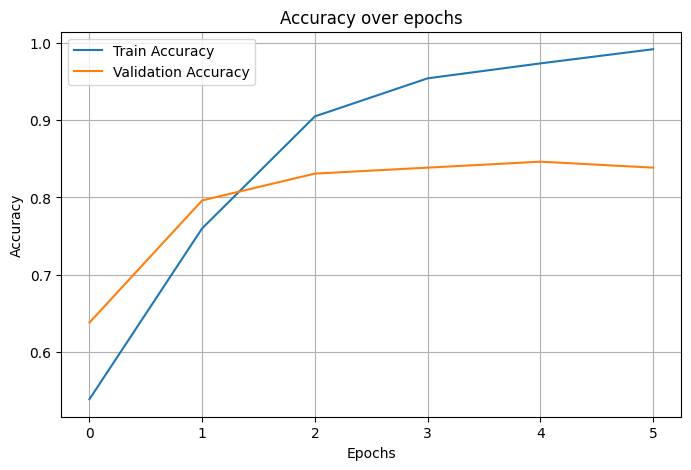

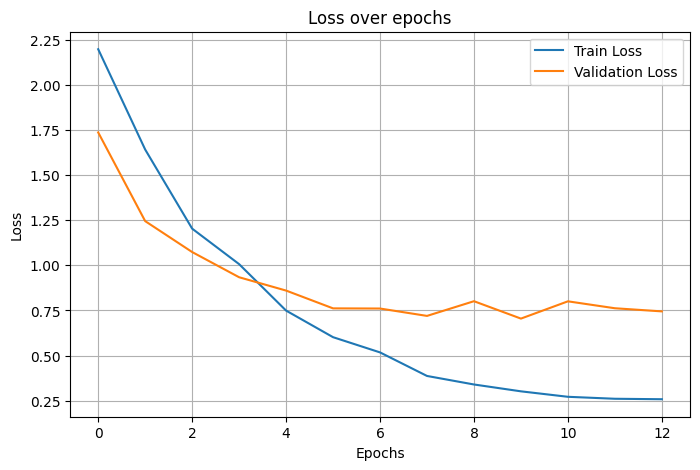

In [47]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(8,5))
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.title("Accuracy over epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Loss plot
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Loss over epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


### 8.1 Clasificación por clase
- **Accuracy total:** 0.97
- **Macro F1-score:** 0.97

### 8.2 Matriz de confusión

- **Recall (Fake):** 0.95 → El modelo detecta casi todas las noticias falsas.
- **Precision (Fake):** 0.98 → Los falsos positivos son mínimos.




              precision    recall  f1-score   support

        Real       0.88      0.84      0.86        87
        Fake       0.71      0.87      0.79        86
      Satira       0.94      0.78      0.86        87

    accuracy                           0.83       260
   macro avg       0.85      0.83      0.83       260
weighted avg       0.85      0.83      0.83       260

[[73 12  2]
 [ 9 75  2]
 [ 1 18 68]]


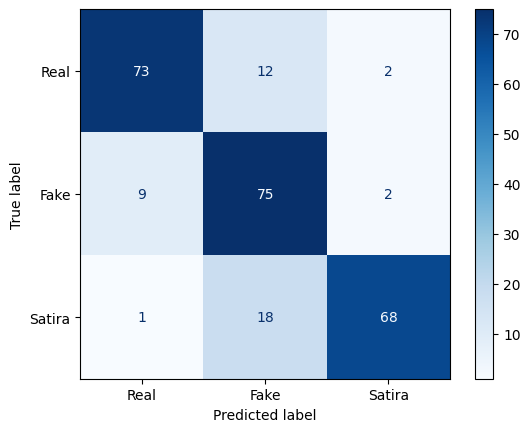

In [49]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Modo evaluación
meta_fc.eval()
gcn_conv.eval()
concat_fc1.eval()
output_fc.eval()

with torch.no_grad():
    x_gnn_test = F.relu(meta_fc(torch.tensor(X_meta_test, dtype=torch.float32).to(device)))
    adj_dense_test = torch.tensor(adj_enriched_test, dtype=torch.float32).to(device)
    edge_index_test, _ = dense_to_sparse(adj_dense_test)

    x_gnn_test = F.relu(gcn_conv(x_gnn_test, edge_index_test))
    x_gnn_test = dropout(x_gnn_test)

    text_input_test = torch.tensor(X_text_test, dtype=torch.float32).to(device)
    x_concat_test = torch.cat([text_input_test, x_gnn_test], dim=1)

    x_test = F.relu(concat_fc1(x_concat_test))
    x_test = dropout(x_test)
    logits_test = F.log_softmax(output_fc(x_test), dim=1)

    pred_labels = logits_test.argmax(dim=1).cpu().numpy()

# Reporte de clasificación
print(classification_report(y_test, pred_labels, target_names=["Real", "Fake", "Satira"]))

# Matriz de confusión
cm = confusion_matrix(y_test, pred_labels)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Real", "Fake", "Satira"])
disp.plot(cmap='Blues')


In [58]:
# Get prediction probabilities, not just classifications
probs = F.softmax(logits_test, dim=1)
fake_confidence = probs[:, 1].cpu().numpy()
print(f"Mean confidence for fake predictions: {fake_confidence[pred_labels==1].mean():.3f}")
print(f"Mean confidence for real predictions: {fake_confidence[pred_labels==0].mean():.3f}")
print(f"Mean confidence for sat predictions: {fake_confidence[pred_labels==2].mean():.3f}")


Mean confidence for fake predictions: 0.910
Mean confidence for real predictions: 0.049
Mean confidence for sat predictions: 0.063


In [51]:
# What real news is being misclassified as fake?
false_positive_indices = np.where((y_test == 0) & (pred_labels == 1))[0]
print(f"False positive examples: {len(false_positive_indices)}")
# Examine these specific texts to understand the pattern

False positive examples: 12


### 9. Conclusión

El modelo híbrido supera significativamente al modelo textual puro (BETO + MLP), logrando un desempeño robusto en ambas clases. La integración de señales estructurales y lingüísticas permite mejorar la detección de desinformación, especialmente en casos más sutiles.

> Este resultado valida la hipótesis central de la tesis: **el contexto estructural y narrativo aporta valor significativo al análisis automático de veracidad**.

In [52]:
# Quick BETO-only baseline test
from sklearn.linear_model import LogisticRegression
lr_baseline = LogisticRegression(max_iter=1000)
lr_baseline.fit(X_text_train, y_train)
beto_baseline_acc = lr_baseline.score(X_text_test, y_test)
print(f"BETO-only baseline accuracy: {beto_baseline_acc:.4f}")

BETO-only baseline accuracy: 0.8423


In [53]:
probs = F.softmax(logits_test, dim=1).detach().cpu().numpy()
y_score = probs[:, 1]  # Probabilidad de ser FAKE

In [54]:
from sklearn.metrics import roc_auc_score

# y_test: tus etiquetas verdaderas (0 = real, 1 = fake, 2 = satira)
# y_score: tus probabilidades de ser FAKE (columna 1)
# For multi-class, roc_auc_score needs a multi_class strategy
roc_auc = roc_auc_score(y_test, probs, multi_class='ovr', average='macro')
print(f"AUROC: {roc_auc:.4f}")

AUROC: 0.9260


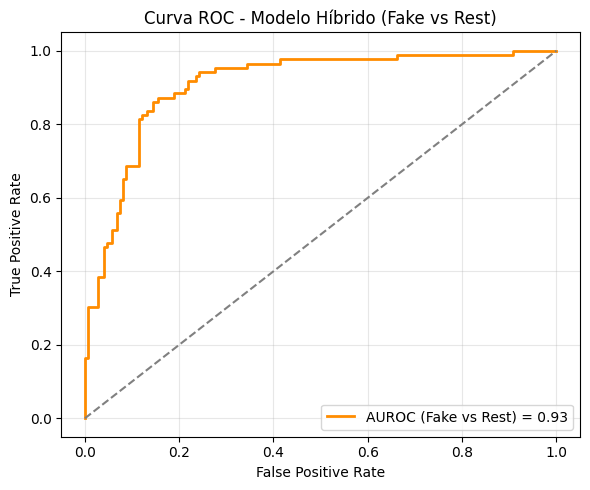

In [55]:
from sklearn.metrics import roc_curve

# Assuming 'Fake' is class 1 and 'Real' and 'Satira' are other classes.
# Plot ROC for 'Fake' class (label 1) against all other classes.
# We need to convert the true labels to binary (1 for Fake, 0 otherwise)
y_true_binary = (y_test == 1)
# And use the probability of the Fake class
y_score_fake = probs[:, 1]

fpr, tpr, thresholds = roc_curve(y_true_binary, y_score_fake)

plt.figure(figsize=(6, 5))
# Use the macro-averaged AUROC calculated previously
plt.plot(fpr, tpr, label=f"AUROC (Fake vs Rest) = {roc_auc:.2f}", color="darkorange", lw=2)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - Modelo Híbrido (Fake vs Rest)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 10. Benchmark del modelo



In [ ]:
!git clone https://github.com/jpposadas/FakeNewsCorpusSpanish.git

In [ ]:
columns=["CATEGORY", "SOURCE", "HEADLINE", "TEXT", "LINK"]
test = pd.read_excel("/content/FakeNewsCorpusSpanish/test.xlsx", index_col = None, usecols=columns)

test.head()

In [ ]:
df_test = pd.DataFrame()
df_test["TEXTO"] = (test["HEADLINE"].fillna("").astype(str) + ". " + test["TEXT"].fillna("").astype(str))
df_test["LABEL"] = test["CATEGORY"].astype(str).str.lower().map({"true":0,"real":0,"false":1,"fake":1, "satira":2}).astype(int)
df_test["FUENTE"] = test["SOURCE"].fillna("desconocido").astype(str)

# 3) FUENTE_COD (reusa el encoder del train si existe; si no, encódalo aquí)
if "le_fuente" in globals():
    fmap = {cls:i for i,cls in enumerate(le_fuente.classes_)}
    unk  = fmap.get("desconocido", 0)
    df_test["FUENTE_COD"] = df_test["FUENTE"].map(lambda x: fmap.get(x, unk)).astype(int)
else:
    df_test["FUENTE_COD"] = LabelEncoder().fit_transform(df_test["FUENTE"])

# 4) Features numéricas crudas
df_test["LONGITUD"]  = df_test["TEXTO"].str.split().str.len().astype(float)
df_test["POLARIDAD"] = df_test["TEXTO"].apply(get_sentiment).astype(float)   # usa tu misma función
df_test["CLICKBAIT"] = test["HEADLINE"].fillna("").astype(str).apply(clickbait_score).astype(float)

df_test.head()


In [ ]:
scaler = MinMaxScaler()
df_test[['LONGITUD_NORM', 'POLARIDAD_NORM', 'CLICKBAIT_NORM']] = scaler.fit_transform(
    df_test[['LONGITUD', 'POLARIDAD', 'CLICKBAIT']]
)

# Crear matriz metadata final
metadata_gnn = np.concatenate([
    df_test['FUENTE_COD'].values.reshape(-1,1),
    df_test[['LONGITUD_NORM', 'POLARIDAD_NORM', 'CLICKBAIT_NORM']].values
], axis=1)


In [ ]:
df_test.head()

In [ ]:
X_text_bench = generate_embeddings(df_test['TEXTO'])
X_meta_bench = metadata_gnn.astype(np.float32)
y_bench = df_test['LABEL'].to_numpy()

# 2) Construir grafo (mismos umbrales que en tu código)
fuentes_b = X_meta_bench[:, 0]
fechas_b = X_meta_bench[:, 1]
polaridades_b = X_meta_bench[:, 3]

sim_text_b = cosine_similarity(X_text_bench)
adj_text_b = (sim_text_b > 0.8).astype(np.float32)
adj_fuente_b = np.equal.outer(fuentes_b, fuentes_b).astype(np.float32)
adj_fecha_b = (np.abs(fechas_b[:, None] - fechas_b[None, :]) <= 0.05).astype(np.float32) if np.std(fechas_b) > 1e-6 else np.zeros_like(adj_text_b)
adj_polaridad_b = (np.abs(polaridades_b[:, None] - polaridades_b[None, :]) <= 0.1).astype(np.float32)

adj_bench = np.clip(adj_text_b + adj_fuente_b + adj_fecha_b + adj_polaridad_b, 0, 1)
np.fill_diagonal(adj_bench, 0)

In [ ]:
meta_fc.eval(); gcn_conv.eval(); concat_fc1.eval(); output_fc.eval()
with torch.no_grad():
    # --- FIX DIMENSIONES METADATA (pad/recorte automático) ---
    xmb = torch.tensor(X_meta_bench, dtype=torch.float32, device=device)
    need = meta_fc.in_features
    have = xmb.shape[1]
    if have < need:
        # rellenamos con 0.5 (valor neutro si usaste MinMaxScaler) al FINAL
        pad = torch.full((xmb.size(0), need - have), 0.5, device=device)
        xmb = torch.cat([xmb, pad], dim=1)
    elif have > need:
        # si sobran columnas, recorta
        xmb = xmb[:, :need]

    x_gnn_b = F.relu(meta_fc(xmb))
    edge_index_b, _ = dense_to_sparse(torch.tensor(adj_bench, dtype=torch.float32, device=device))
    x_gnn_b = dropout(F.relu(gcn_conv(x_gnn_b, edge_index_b)))
    x_concat_b = torch.cat([torch.tensor(X_text_bench, dtype=torch.float32, device=device), x_gnn_b], dim=1)
    x_b = dropout(F.relu(concat_fc1(x_concat_b)))
    logits_b = F.log_softmax(output_fc(x_b), dim=1)
    y_pred_b = logits_b.argmax(dim=1).cpu().numpy()


In [ ]:
print(classification_report(y_bench, y_pred_b, target_names=["Real", "Fake", "Satira"]))

In [ ]:
cm_benchmark = confusion_matrix(y_bench, y_pred_b)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_benchmark, display_labels=["Real", "Fake", "Satira"])
disp.plot(cmap='Blues')